In [1]:
import numpy as np
import pandas as pd
import datetime as dt
import matplotlib.pyplot as plt
%matplotlib inline

# Objectif du notebook

L'objectif est ici de construire un dataset de variables explicatives à partir de données météo, données dites métier, car il a été démontré lors de la phase de visualisation, qu'il y avait corrélation entre ces données et l'énergie consommée.

Le dataset utilisé provient du domaine public : AROME :
https://public.opendatasoft.com/explore/dataset/donnees-synop-essentielles-omm/

La visualisation des données de nébulosité montre un changement notable dans le processus de mesure. Ces données ne pourront pas être utilisée de manière consistante.

Aussi, nous ne pourrons pas utiliser des données météorologiques comme données métier pouvant expliquer la production solaire. Nous utiliserons les valeurs d'ensoleillement comme régresseur exogène pour cette filière d'énergie.

De manière générale, les variables inconsistantes sur la période sont écartées (rafales, etc).

# Import et préparation des données météorologiques AROME

In [2]:
df = pd.read_csv('./datasource/meteo_synop.csv', sep=';',
                nrows = 10)
df.columns

Index(['ID OMM station', 'Date', 'Pression au niveau mer',
       'Variation de pression en 3 heures', 'Type de tendance barométrique',
       'Direction du vent moyen 10 mn', 'Vitesse du vent moyen 10 mn',
       'Température', 'Point de rosée', 'Humidité', 'Visibilité horizontale',
       'Temps présent', 'Temps passé 1', 'Temps passé 2', 'Nebulosité totale',
       'Nébulosité  des nuages de l' étage inférieur',
       'Hauteur de la base des nuages de l'étage inférieur',
       'Type des nuages de l'étage inférieur',
       'Type des nuages de l'étage moyen',
       'Type des nuages de l'étage supérieur', 'Pression station',
       'Niveau barométrique', 'Géopotentiel',
       'Variation de pression en 24 heures',
       'Température minimale sur 12 heures',
       'Température minimale sur 24 heures',
       'Température maximale sur 12 heures',
       'Température maximale sur 24 heures',
       'Température minimale du sol sur 12 heures',
       'Méthode de mesure Température du

In [3]:
df = pd.read_csv('./datasource/meteo_synop.csv', sep=';',
                usecols = ['Date',
                           'communes (name)', 'communes (code)', 'region (name)',
                           'Latitude', 'Longitude',
                           'Température (°C)', # exog consommation
                           'Pression au niveau mer', 'Humidité', # exog éolien
                           'Pression station', # exog éolien
                           'Vitesse du vent moyen 10 mn',# exog éolien
                           'Précipitations dans les 3 dernières heures', # exog éolien
                           ])
df.tail(1)

,Date,Pression au niveau mer,Vitesse du vent moyen 10 mn,Humidité,Pression station,Précipitations dans les 3 dernières heures,Température (°C),Latitude,Longitude,communes (name),communes (code),region (name)
2032904,2021-09-29T02:00:00+02:00,102100.0,3.4,73.0,100120.0,0.0,14.0,47.059167,2.359833,Bourges,18033,Centre-Val de Loire


In [4]:
# On exclut les départements qui ne sont pas en métropole :
df = df[~df['region (name)'].isin(['Martinique', 'Guyane', 'Corse', 'La Réunion', 'Guadeloupe', 'Mayotte',
                      'Terres australes et antarctiques françaises', 'Saint-Barthélemy', 'Saint-Pierre-et-Miquelon'])]

In [5]:
# On exclut les stations que l'on ne peut rattacher à une commune, à une région
df = df[df['communes (code)'].isna() == False]

In [6]:
df['region (name)'].replace(to_replace = ['Occitanie', 'Normandie', 'Bretagne', "Provence-Alpes-Côte d'Azur", 
                                    'Hauts-de-France', 'Île-de-France', 'Grand Est', 'Nouvelle-Aquitaine',
                                    'Bourgogne-Franche-Comté', 'Pays de la Loire', 'Auvergne-Rhône-Alpes',
                                    'Centre-Val de Loire'],
                      value = ['O', 'N', 'B', 'PACA',
                               'HF', 'IDF', 'GE', 'NlleA',
                               'BFC', 'PDL', 'AURA',
                               'CVDL'], inplace = True)

In [7]:
df['communes (code)'] = df['communes (code)'].astype(int)

In [8]:
# On crée un DataFrame pour les coordonnées des stations
df_geo = df[['communes (name)', 'communes (code)', 'region (name)', 'Latitude', 'Longitude']]
df_geo.head(1)

,communes (name),communes (code),region (name),Latitude,Longitude
0,Millau,12145,O,44.1185,3.0195


In [9]:
df.rename({'Température (°C)' : 'Temperature',
        'communes (code)' : 'Communes',
        'region (name)' :  'Regions',
        'Pression au niveau mer' : 'Pression mer',
        'Pression station' : 'Pression station',
        'Précipitations dans les 3 dernières heures' : 'Pluie',
        'Humidité' : 'Humidite',
        'Vitesse du vent moyen 10 mn' : 'Vent',
        'Précipitations dans les 3 dernières heures' : 'Pluie'
        }, axis = 1, inplace = True)
df.columns

Index(['Date', 'Pression mer', 'Vent', 'Humidite', 'Pression station', 'Pluie',
       'Temperature', 'Latitude', 'Longitude', 'communes (name)', 'Communes',
       'Regions'],
      dtype='object')

In [10]:
df['Dates']=df['Date'].astype(str).str[:-6]

In [11]:
df['Dates'] = pd.to_datetime(df['Dates'], yearfirst = True)

In [12]:
df.sort_values(by = ['Regions', 'Communes', 'Dates'], inplace = True)

In [13]:
# On garde la période correspondant à notre dataset d'étude
df = df[(df['Dates'] >= '2013-01-01') & (df['Dates'] < '2021-11-01')]

In [14]:
df = df.drop(['Longitude', 'Latitude', 'Date'], axis = 1)
df.head(1)

,Pression mer,Vent,Humidite,Pression station,Pluie,Temperature,communes (name),Communes,Regions,Dates
377791,101810.0,3.1,87.0,100900.0,0.0,7.1,Montélimar,26198,AURA,2013-01-01 01:00:00


In [15]:
df['Heure'] = df['Dates'].dt.hour

In [16]:
df['Heure'].replace(to_replace = [ 1, 4, 7, 10, 13, 16, 19, 22, 5, 8, 11, 14, 17, 20, 23, 2],
                           value = [ 1, 1, 1, 1, 1, 1, 1, 1, 2, 2, 2, 2, 2, 2, 2, 2], inplace = True)

In [17]:
df['Heure'] = df['Heure'].astype(str)

In [18]:
df['Heure'] = '0' + df['Heure'] + ':00:00'

In [19]:
df['Heure'] = pd.to_timedelta(df['Heure'])#, unit = 'hours')

In [20]:
df['Dates'] = df['Dates'] - df['Heure']

In [21]:
df = df.drop(['Heure'], axis = 1)
df['Dates'] = pd.to_datetime(df['Dates'], yearfirst = True)

df.tail(13)

,Pression mer,Vent,Humidite,Pression station,Pluie,Temperature,communes (name),Communes,Regions,Dates
1605284,99960.0,2.9,91.0,99650.0,1.2,12.3,Saint-Aignan-Grandlieu,44150,PDL,2021-10-30 09:00:00
1869533,100170.0,4.7,72.0,99870.0,0.2,16.4,Saint-Aignan-Grandlieu,44150,PDL,2021-10-30 12:00:00
1519471,100360.0,4.6,64.0,100050.0,0.0,15.7,Saint-Aignan-Grandlieu,44150,PDL,2021-10-30 15:00:00
2005601,100600.0,2.5,82.0,100290.0,0.0,12.3,Saint-Aignan-Grandlieu,44150,PDL,2021-10-30 18:00:00
1502153,100650.0,2.7,89.0,100340.0,0.0,11.2,Saint-Aignan-Grandlieu,44150,PDL,2021-10-30 21:00:00
1580631,100500.0,4.4,92.0,100190.0,0.0,11.2,Saint-Aignan-Grandlieu,44150,PDL,2021-10-31 00:00:00
2028889,100260.0,4.9,93.0,99950.0,0.0,13.3,Saint-Aignan-Grandlieu,44150,PDL,2021-10-31 03:00:00
1519475,99900.0,8.3,87.0,99590.0,0.0,13.2,Saint-Aignan-Grandlieu,44150,PDL,2021-10-31 06:00:00
1892225,99870.0,7.4,94.0,99560.0,2.8,14.4,Saint-Aignan-Grandlieu,44150,PDL,2021-10-31 09:00:00
1659540,100010.0,5.0,82.0,99700.0,4.3,14.9,Saint-Aignan-Grandlieu,44150,PDL,2021-10-31 12:00:00


## Localisation des stations

Il est important de pouvoir localiser les stations car suivant les informations que nous souhaitons collecter comme variables explicatives, un biais peut être induit par l'intégration de station non représentatives.

Par exemple, pour la production éolienne, il convient de ne conserver les stations qu'aux endroits où il y a un parc éolien.

In [22]:
# On récupère le DataFrame créé précédemment.
df_geo = df_geo[(df_geo['Latitude']>0)&(df_geo['Longitude']>-20)]

In [23]:
# Chaque station a autant de ligne que d'enregistrements météorologiques (chaque 3h).
df_geo_light = df_geo.drop_duplicates()

In [24]:
# Calcul des coordonnées à partir du rayon de la terre et des angles de longitude et lattitude.
df_geo_light['x'] = df_geo_light['Longitude'] * (6378137 * np.pi/180.0)
df_geo_light['y'] = np.log(np.tan((90 + df_geo_light['Latitude']) * np.pi/360.0)) * 6378137

<ipython-input-24-1a3aad86aed5>:2: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df_geo_light['x'] = df_geo_light['Longitude'] * (6378137 * np.pi/180.0)
<ipython-input-24-1a3aad86aed5>:3: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df_geo_light['y'] = np.log(np.tan((90 + df_geo_light['Latitude']) * np.pi/360.0)) * 6378137


In [25]:
from bokeh.models import ColumnDataSource, LabelSet
from bokeh.tile_providers import get_provider
from bokeh.plotting import figure, output_notebook, show
output_notebook()
source = ColumnDataSource(df_geo_light)
tuile = get_provider("CARTODBPOSITRON")

Loading BokehJS ...

In [26]:
figdata=figure(x_axis_type='mercator', y_axis_type='mercator')
figdata.add_tile(tuile)
figdata.circle(
    source = source,
    x='x',
    y='y',
    size=10,
    color='blue')
etiquette=LabelSet(source=source,
                  x='x',
                  y='y',
                  text='communes (code)',
                  x_offset=5,
                  y_offset=5,
                  text_font_size='8pt')
figdata.add_layout(etiquette)

In [27]:
show(figdata)

## Suppression des stations non représentatives

Le site Internet ci-dessous permet de visualiser l'emplacement des parcs éoliens en France et donc de recouper avec la localisation des stations météorologiques que nous avons représentée ci-dessus.

https://mapthenews.maps.arcgis.com/apps/instant/media/index.html?appid=11fbf3f54b4a48e49320cd97333c4f1d

Nous n'avons pas de données concernant l'implantation des équipements de production d'énergie solaire.

Pour la production hydraulique, nous partirons sur l'hypothèse que la pluviométrie maximale d'une région est celle à retenir. En effet, une typologie de pluie provient du relief. On peut considérer que les régions avec du relief sont donc les plus pluvieuses. Celà correspond généralement à l'implantation des équipements hydrauliques.

In [28]:
# On peut ainsi affiner la qualité des données pour la production éolienne en ne sélectionnant que les stations pertinentes :
df_eol = df[df['Communes'].isin([54523, 51449, 10030,
                                    80001, 59256, #59256 ajouté pour données manquantes 1ère semaine d'avril 21
                                    14137,
                                    29075, 35281,
                                    18033,
                                    86194, 17323,
                                    12145, 66136,
                                    13054,
                                    26198,
                                    21473,
                                    44150,
                                    91027])][['Dates', 'Regions', 'Pression mer', 'Vent', 'Humidite', 'Pression station', 'Pluie', 'Temperature']]

In [29]:
df_hydro = df[['Dates', 'Regions', 'Pluie']]

In [30]:
df_conso = df[['Dates', 'Regions', 'Temperature']]

## Aggrégation au niveau des régions

In [31]:
# index de time series correspondant à la période d'étude
idx = pd.date_range(start = "2013-1-1", end = "2021-10-31 23:00:00", freq="3H")
idx = pd.to_datetime(idx)
idx.shape

(25808,)

### Eolien

In [32]:
df_eol = df_eol.groupby(['Dates', 'Regions']).mean()
df_eol.reset_index(inplace = True)
df_eol = df_eol.sort_values(by = ['Regions', 'Dates'])

In [33]:
df_eol.head(1)

,Dates,Regions,Pression mer,Vent,Humidite,Pression station,Pluie,Temperature
0,2013-01-01,AURA,101810.0,3.1,87.0,100900.0,0.0,7.1


In [34]:
list_regions_eol = df_eol['Regions'].unique()

In [35]:
df_eol_per_reg = []
for region in list_regions_eol:
    df_eol_per_reg.append(df_eol[df_eol['Regions'] == region])

In [36]:
# on vérifie s'il y a des "trous" dans notre série temporelle
for i in df_eol_per_reg:
    print(i.shape)

(25734, 8)
(25787, 8)
(25637, 8)
(25764, 8)
(25789, 8)
(25786, 8)
(25770, 8)
(25499, 8)
(25788, 8)
(25784, 8)
(25777, 8)
(25771, 8)


In [37]:
# on comble les "trous"
for i, df_eol_region in enumerate(df_eol_per_reg):
    df_eol_region = df_eol_region.set_index('Dates')
    df_eol_region = df_eol_region.reindex(idx)
    df_eol_region['Regions'] = df_eol_region['Regions'].fillna(df_eol_region['Regions'].mode()[0])
    df_eol_region[['Pluie']] = df_eol_region[['Pluie']].fillna(0)
    df_eol_region[['Temperature', 'Pression mer', 'Pression station', 'Humidite', 'Vent']] = df_eol_region[['Temperature', 'Pression mer', 'Pression station', 'Humidite', 'Vent']].interpolate()
    df_eol_per_reg[i] = df_eol_region

In [38]:
for i in df_eol_per_reg:
    print(i.shape)

(25808, 7)
(25808, 7)
(25808, 7)
(25808, 7)
(25808, 7)
(25808, 7)
(25808, 7)
(25808, 7)
(25808, 7)
(25808, 7)
(25808, 7)
(25808, 7)


In [39]:
eol_region = df_eol_per_reg[0]
for region in df_eol_per_reg[1:]:
    eol_region = pd.concat([eol_region, region])

In [40]:
eol_region.shape

(309696, 7)

In [41]:
eol_region.isna().sum()

Regions             0
Pression mer        0
Vent                0
Humidite            0
Pression station    0
Pluie               0
Temperature         0
dtype: int64

In [42]:
eol_region.reset_index(inplace = True)

In [43]:
eol_region.rename({'index':'Dates'}, axis = 1, inplace = True)
eol_region.set_index('Dates', inplace = True)

In [44]:
list_variables_eol = eol_region.columns[1:]

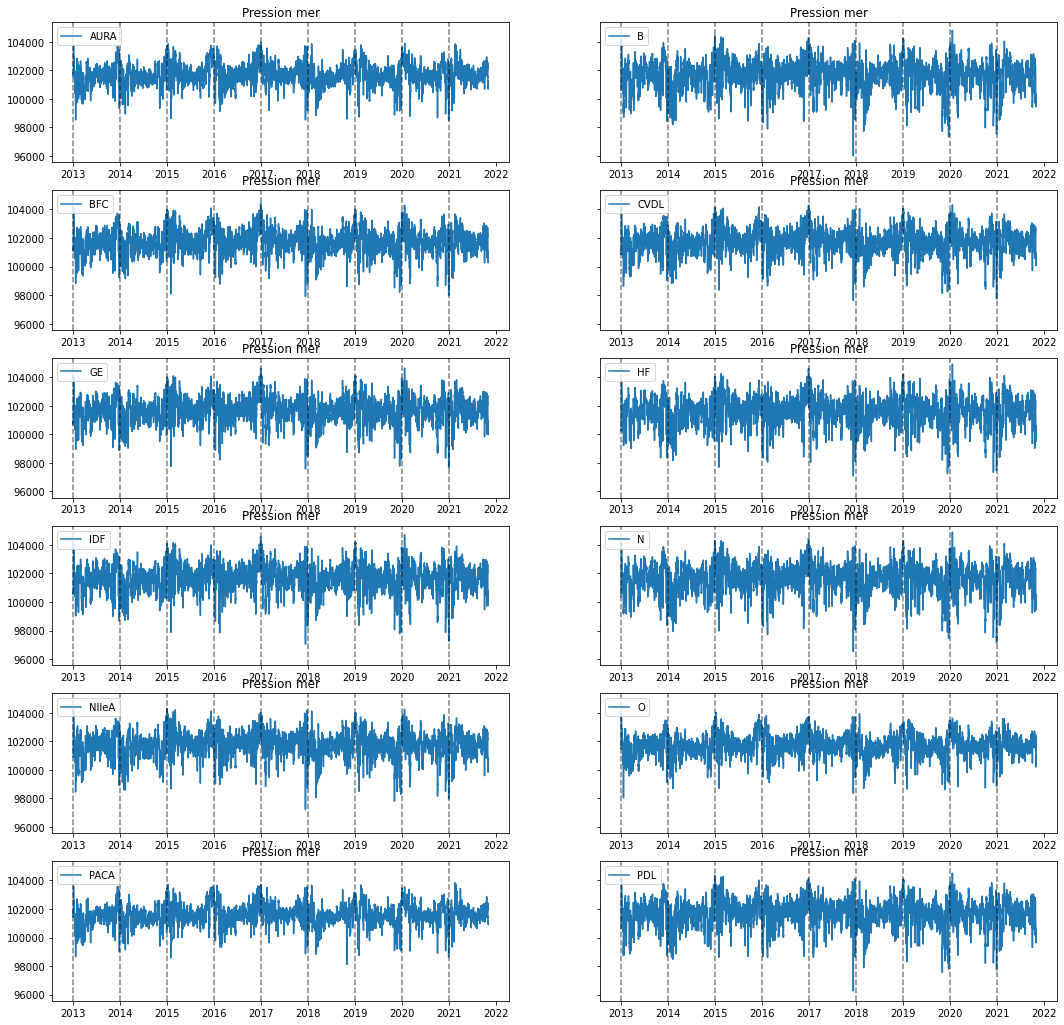

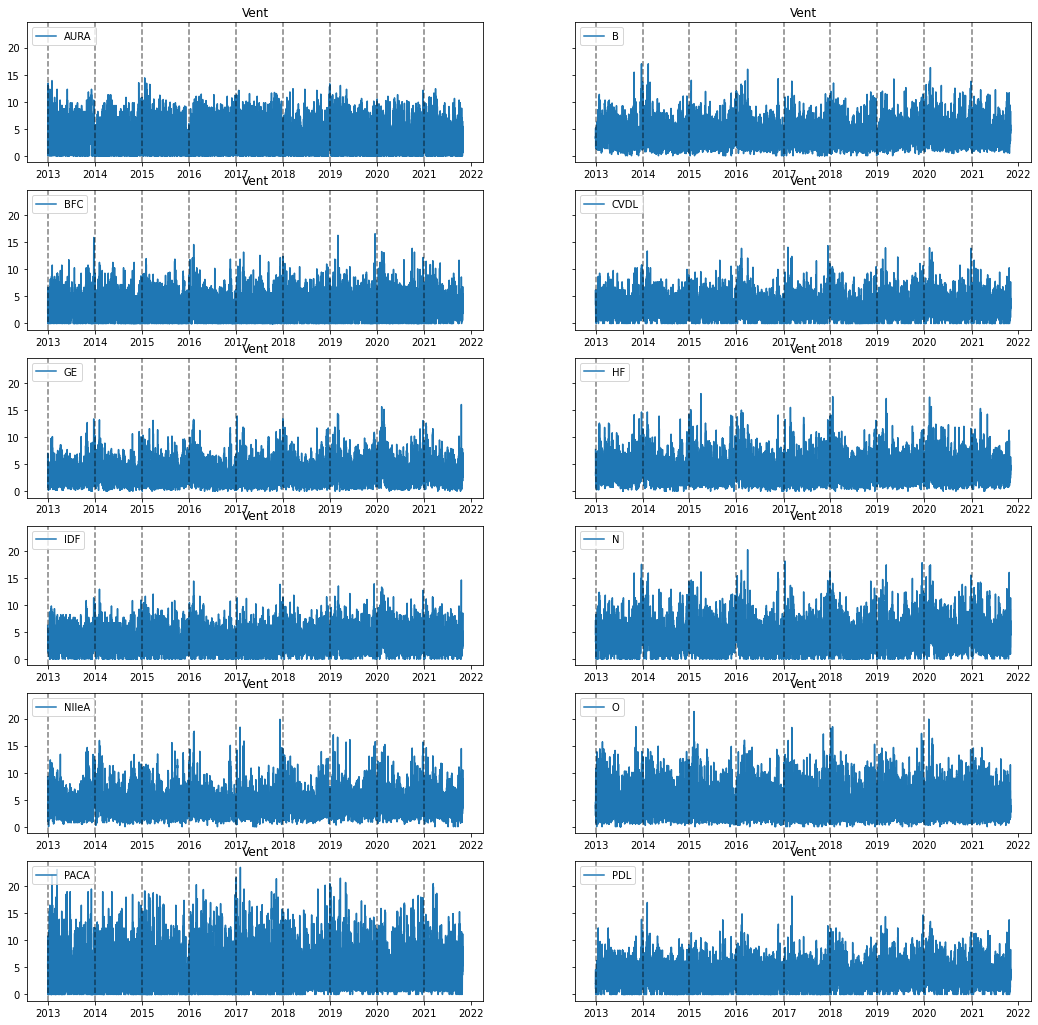

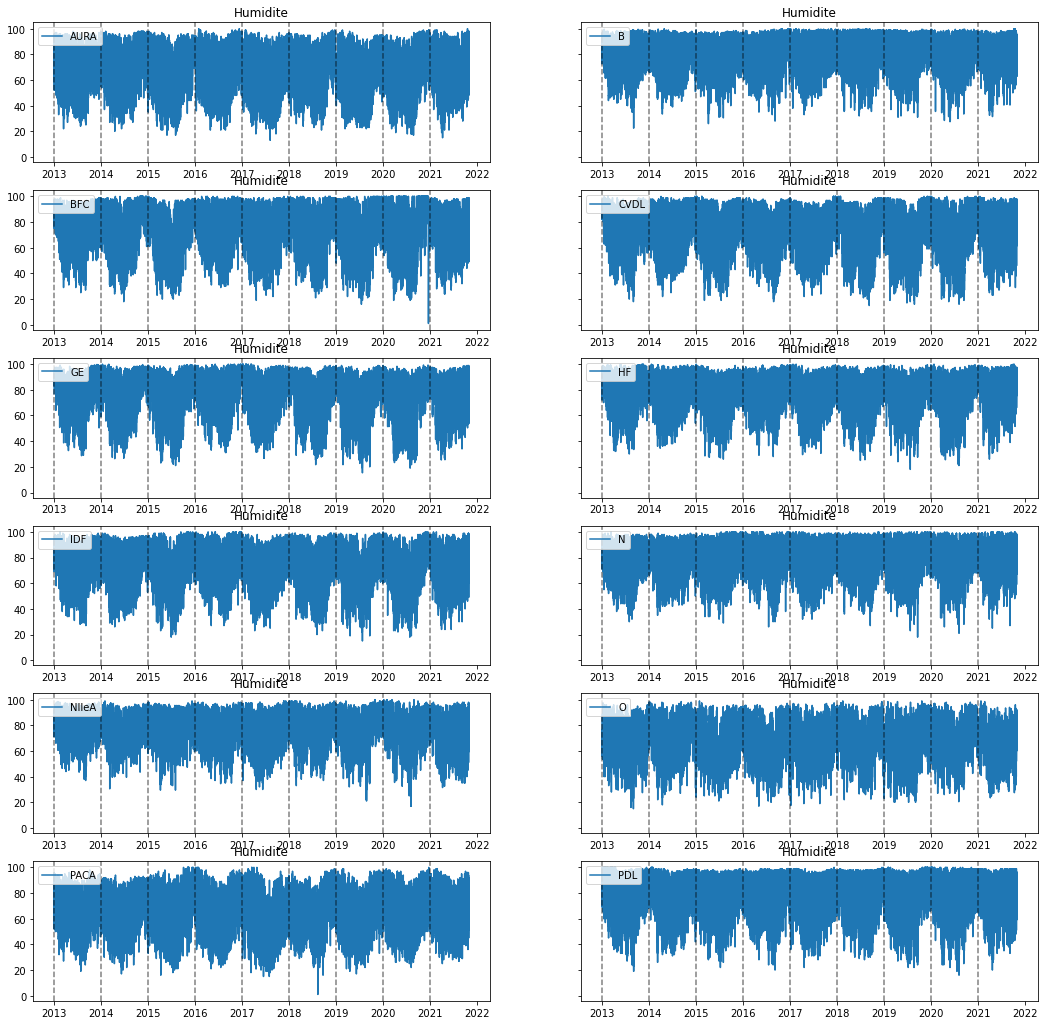

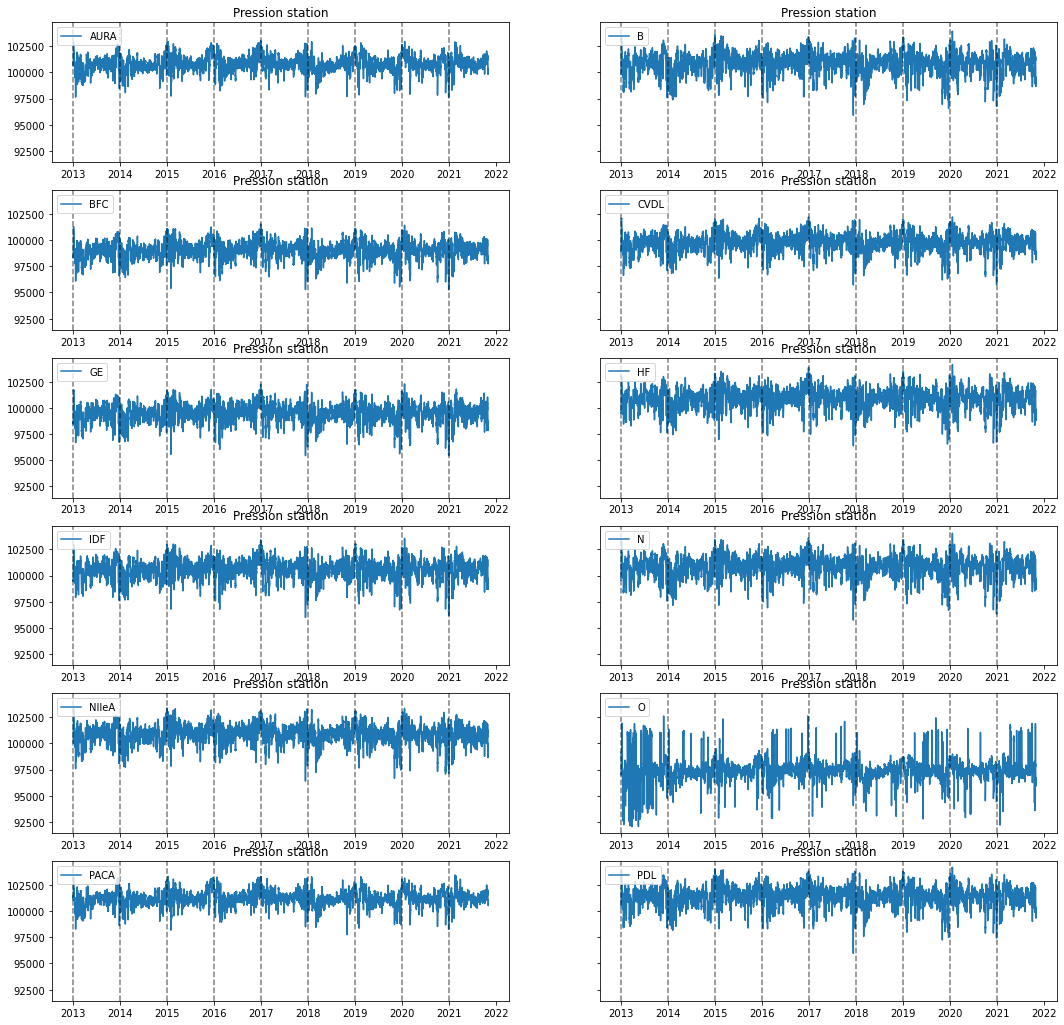

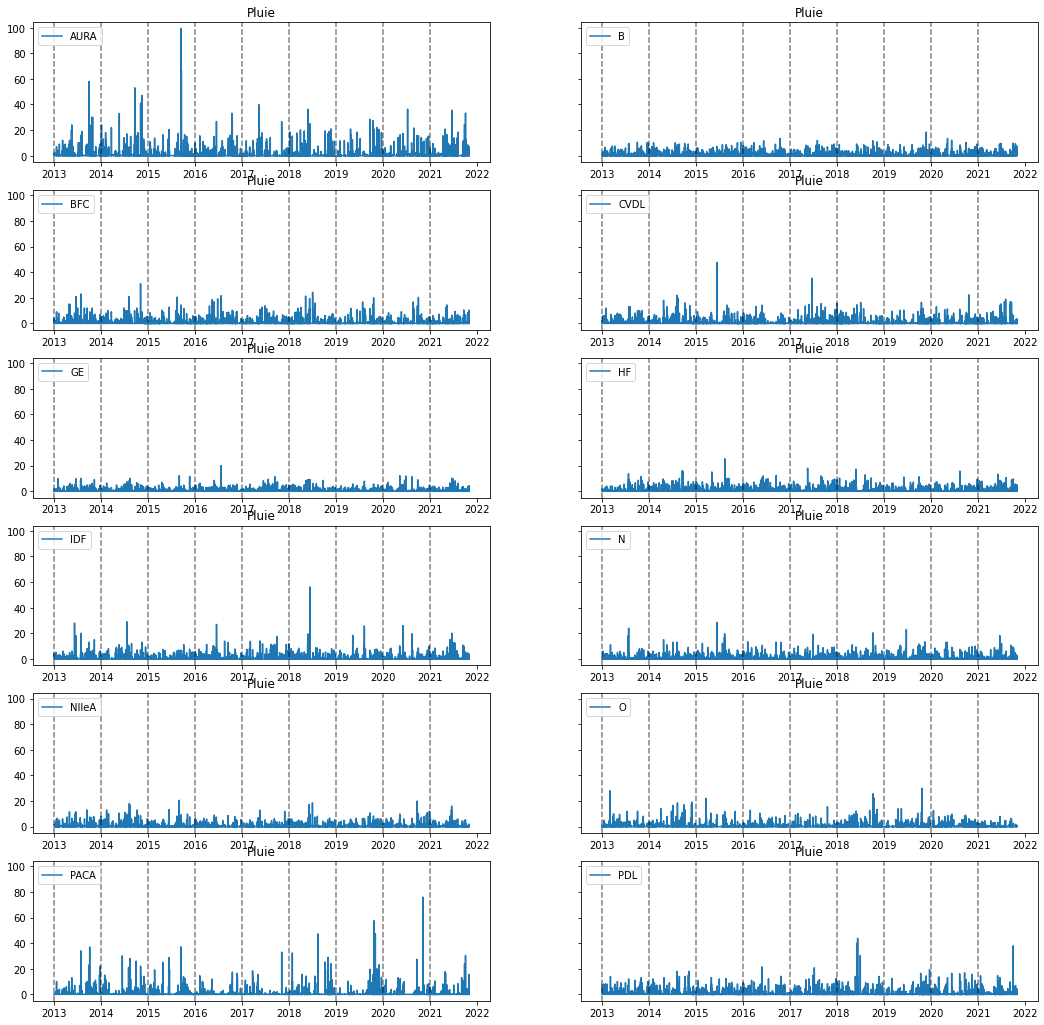

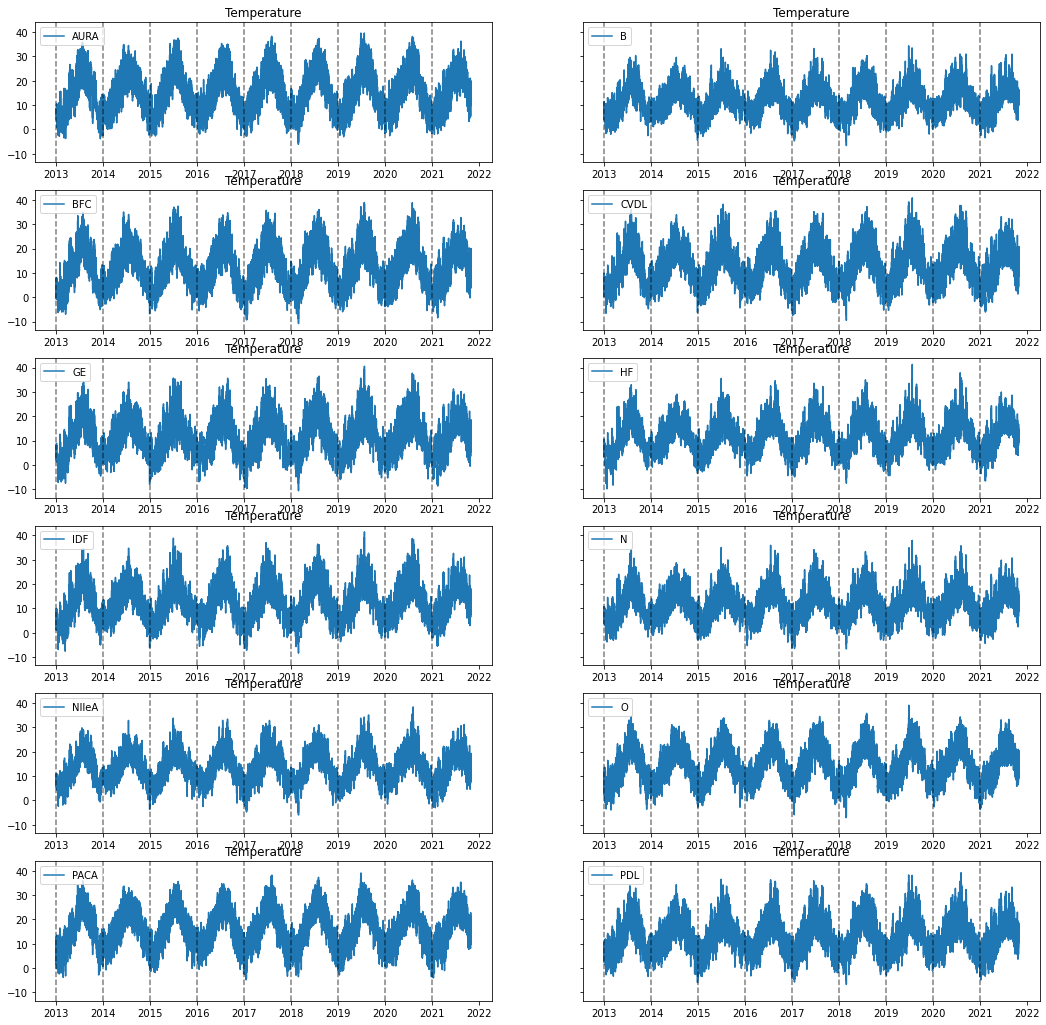

In [45]:
for variable in list_variables_eol:
    fig, ax = plt.subplots(6,2, figsize=(18, 18), sharey = True)
    for i, axi in enumerate(ax.flat):
        axi.plot(eol_region[eol_region['Regions'] == list_regions_eol[i]][variable], label=list_regions_eol[i])
        axi.legend(loc = 'upper left')
        axi.set_title(variable)
        for year in range(2013, 2022):
            axi.axvline(pd.to_datetime(str(year)+'-01-01'), color='k', linestyle='--', alpha=0.5);


In [46]:
eol_region.head(1)

,Regions,Pression mer,Vent,Humidite,Pression station,Pluie,Temperature
Dates,,,,,,,
2013-01-01,AURA,101810.0,3.1,87.0,100900.0,0.0,7.1


In [47]:
eol_region['Diff_pression'] = eol_region['Pression station'] - eol_region['Pression mer']
eol_region.drop(['Pression station', 'Pression mer'], axis = 1, inplace = True)
eol_region.head(1)

,Regions,Vent,Humidite,Pluie,Temperature,Diff_pression
Dates,,,,,,
2013-01-01,AURA,3.1,87.0,0.0,7.1,-910.0


### Consommation

In [48]:
df_conso = df_conso.groupby(['Dates', 'Regions']).mean()
df_conso.reset_index(inplace = True)
df_conso = df_conso.sort_values(by = ['Regions', 'Dates'])

In [49]:
df_conso.head(1)

,Dates,Regions,Temperature
0,2013-01-01,AURA,7.375


In [50]:
list_regions_conso = df_conso['Regions'].unique()

In [51]:
df_conso_per_reg = []
for region in list_regions_conso:
    df_conso_per_reg.append(df_conso[df_conso['Regions'] == region])

In [52]:
# on vérifie s'il y a des "trous" dans notre série temporelle
for i in df_conso_per_reg:
    print(i.shape)

(25790, 3)
(25788, 3)
(25637, 3)
(25786, 3)
(25789, 3)
(25786, 3)
(25770, 3)
(25789, 3)
(25788, 3)
(25790, 3)
(25788, 3)
(25771, 3)


In [53]:
# on comble les "trous"
for i, df_conso_region in enumerate(df_conso_per_reg):
    df_conso_region = df_conso_region.set_index('Dates')
    df_conso_region = df_conso_region.reindex(idx)
    df_conso_region['Regions'] = df_conso_region['Regions'].fillna(df_conso_region['Regions'].mode()[0])
    df_conso_region[['Temperature']] = df_conso_region[['Temperature']].interpolate()
    df_conso_per_reg[i] = df_conso_region

In [54]:
for i in df_conso_per_reg:
    print(i.shape)

(25808, 2)
(25808, 2)
(25808, 2)
(25808, 2)
(25808, 2)
(25808, 2)
(25808, 2)
(25808, 2)
(25808, 2)
(25808, 2)
(25808, 2)
(25808, 2)


In [55]:
conso_region = df_conso_per_reg[0]
for region in df_conso_per_reg[1:]:
    conso_region = pd.concat([conso_region, region])

In [56]:
conso_region.shape

(309696, 2)

In [57]:
conso_region.isna().sum()

Regions        0
Temperature    0
dtype: int64

In [58]:
conso_region.reset_index(inplace = True)

In [59]:
conso_region.rename({'index':'Dates'}, axis = 1, inplace = True)
conso_region.set_index('Dates', inplace = True)

In [60]:
list_variables_conso = conso_region.columns[1:]

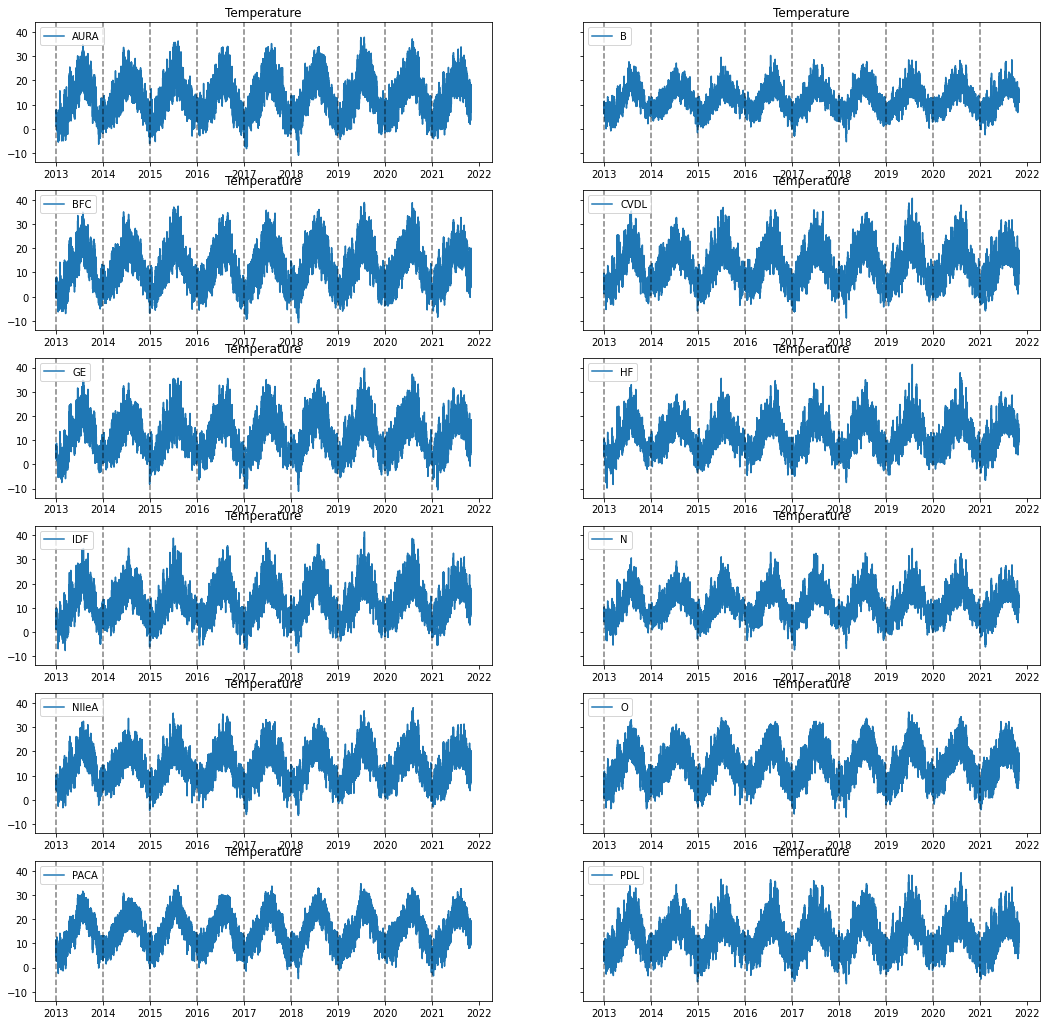

In [61]:
for variable in list_variables_conso:
    fig, ax = plt.subplots(6,2, figsize=(18, 18), sharey = True)
    for i, axi in enumerate(ax.flat):
        axi.plot(conso_region[conso_region['Regions'] == list_regions_conso[i]][variable], label=list_regions_conso[i])
        axi.legend(loc = 'upper left')
        axi.set_title(variable)
        for year in range(2013, 2022):
            axi.axvline(pd.to_datetime(str(year)+'-01-01'), color='k', linestyle='--', alpha=0.5);

### Hydraulique

In [62]:
df_hydro = df_hydro.groupby(['Dates', 'Regions']).max()
df_hydro.reset_index(inplace = True)
df_hydro = df_hydro.sort_values(by = ['Regions', 'Dates'])

In [63]:
df_hydro.head(1)

,Dates,Regions,Pluie
0,2013-01-01,AURA,0.0


In [64]:
list_regions_hydro = df_hydro['Regions'].unique()

In [65]:
df_hydro_per_reg = []
for region in list_regions_hydro:
    df_hydro_per_reg.append(df_hydro[df_hydro['Regions'] == region])

In [66]:
# on vérifie s'il y a des "trous" dans notre série temporelle
for i in df_hydro_per_reg:
    print(i.shape)

(25790, 3)
(25788, 3)
(25637, 3)
(25786, 3)
(25789, 3)
(25786, 3)
(25770, 3)
(25789, 3)
(25788, 3)
(25790, 3)
(25788, 3)
(25771, 3)


In [67]:
# on comble les "trous"
for i, df_hydro_region in enumerate(df_hydro_per_reg):
    df_hydro_region = df_hydro_region.set_index('Dates')
    df_hydro_region = df_hydro_region.reindex(idx)
    df_hydro_region['Regions'] = df_hydro_region['Regions'].fillna(df_hydro_region['Regions'].mode()[0])
    df_hydro_region[['Pluie']] = df_hydro_region[['Pluie']].fillna(0)
    df_hydro_per_reg[i] = df_hydro_region

In [68]:
for i in df_hydro_per_reg:
    print(i.shape)

(25808, 2)
(25808, 2)
(25808, 2)
(25808, 2)
(25808, 2)
(25808, 2)
(25808, 2)
(25808, 2)
(25808, 2)
(25808, 2)
(25808, 2)
(25808, 2)


In [69]:
hydro_region = df_hydro_per_reg[0]
for region in df_hydro_per_reg[1:]:
    hydro_region = pd.concat([hydro_region, region])

In [70]:
hydro_region.shape

(309696, 2)

In [71]:
hydro_region.isna().sum()

Regions    0
Pluie      0
dtype: int64

In [72]:
hydro_region.reset_index(inplace = True)

In [73]:
hydro_region.rename({'index':'Dates'}, axis = 1, inplace = True)
hydro_region.set_index('Dates', inplace = True)

In [74]:
list_variables_hydro = hydro_region.columns[1:]

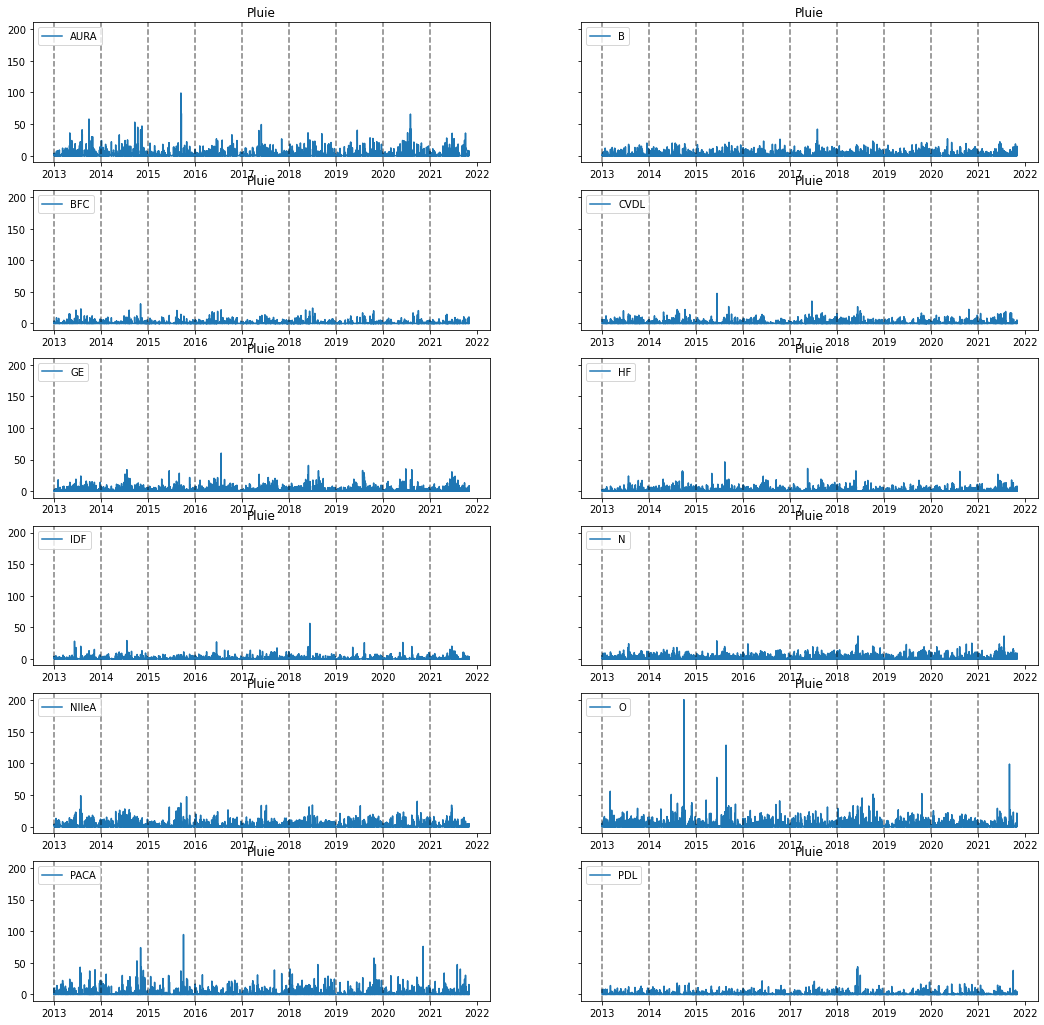

In [75]:
for variable in list_variables_hydro:
    fig, ax = plt.subplots(6,2, figsize=(18, 18), sharey = True)
    for i, axi in enumerate(ax.flat):
        axi.plot(hydro_region[hydro_region['Regions'] == list_regions_hydro[i]][variable], label=list_regions_hydro[i])
        axi.legend(loc = 'upper left')
        axi.set_title(variable)
        for year in range(2013, 2022):
            axi.axvline(pd.to_datetime(str(year)+'-01-01'), color='k', linestyle='--', alpha=0.5);

In [76]:
hydro_region.rename({'Pluie' : 'Pluie_hydro'}, axis = 1, inplace = True)
hydro_region.head(1)

,Regions,Pluie_hydro
Dates,,
2013-01-01,AURA,0.0


### Solaire

In [77]:
solaire = pd.read_csv('./datasource/horaires_soleil.csv', sep = ';', usecols = ['Dates', 'Lever', 'Coucher'])
solaire.head(1)

,Dates,Lever,Coucher
0,2013-01-01 00:00:00,8.75,16.8


In [78]:
# list_regions_sol = ['AURA', 'B', 'BFC', 'CVDL', 'GE', 'HF', 'IDF', 'N', 'NlleA', 'O', 'PACA', 'PDL']
list_regions_sol = list_regions_hydro

In [79]:
list_reg = []
for region in list_regions_sol:
    list_reg.extend([region] * 25808)
len(list_reg)

309696

In [80]:
sol_region = solaire
for region in range(len(list_regions_sol) - 1):
    sol_region = pd.concat([sol_region, solaire])
sol_region.shape

(309696, 3)

In [81]:
sol_region['Regions'] = list_reg
sol_region.set_index('Dates', inplace = True)
sol_region = sol_region.sort_values(by = ['Regions', 'Dates'])
sol_region['Duree_sol'] = sol_region['Coucher'] - sol_region['Lever']
sol_region.drop(['Coucher', 'Lever'], axis = 1, inplace = True)
sol_region

,Regions,Duree_sol
Dates,,
2013-01-01 00:00:00,AURA,8.050000
2013-01-01 03:00:00,AURA,8.050000
2013-01-01 06:00:00,AURA,8.050000
2013-01-01 09:00:00,AURA,8.050000
2013-01-01 12:00:00,AURA,8.050000
...,...,...
2021-10-31 09:00:00,PDL,9.766667
2021-10-31 12:00:00,PDL,9.766667
2021-10-31 15:00:00,PDL,9.766667


## Fichier variables explicatives métier ou régresseurs exogènes

In [82]:
eol_region.drop('Regions', axis = 1, inplace = True)
sol_region.drop('Regions', axis = 1, inplace = True)
hydro_region.drop('Regions', axis = 1, inplace = True)

In [83]:
eol_region.rename({'Pluie' : 'Pluie_eol', 'Temperature' : 'Temperature_eol'}, axis = 1, inplace = True)
conso_region.rename({'Temperature' : 'Temperature_conso'}, axis = 1, inplace = True)
hydro_region.rename({'Pluie' : 'Pluie_hydro'}, axis = 1, inplace = True)

In [84]:
exog = pd.concat([conso_region, eol_region, sol_region, hydro_region], axis = 1)
exog.columns

Index(['Regions', 'Temperature_conso', 'Vent', 'Humidite', 'Pluie_eol',
       'Temperature_eol', 'Diff_pression', 'Duree_sol', 'Pluie_hydro'],
      dtype='object')

In [85]:
exog_3H = exog
exog_3H.to_csv('./exog/exog_3H.csv', sep = ';')